In [1]:
## LSTM packages
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import dataloader, Dataset

### Self defined model and dataset class
from model_and_dataset import time_data, TS_LSTM

### data cleansing and viusalization packages
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import csv

In [2]:
class arguments():
    def __init__(self):
        """
        Hyperparams for the models
        """
        # input_dim: the # of LSTMnodes, also the time series window
        self.input_dim = 12
        # the hidden_dim of the model
        self.hidden_dim= 18

        self.learning_rate = 5e-5
        
        self.training_iter = 500
args = arguments()

In [5]:
tonnage = pd.read_csv("DSNY_Monthly_Tonnage_Data.csv")
Man = tonnage.loc[:,["MONTH","REFUSETONSCOLLECTED"]].groupby(by="MONTH").sum()

In [6]:
Man

,REFUSETONSCOLLECTED
MONTH,
1990 / 01,71.9
1990 / 06,11518.0
1990 / 07,15243.8
1990 / 08,31162.8
1990 / 09,34097.0
...,...
2020 / 02,181326.0
2020 / 03,200958.1
2020 / 04,195651.3


In [7]:
def get_XY(raw_data, window):
    """
    Get the time series data from the pd.Series
    """
    X_data, y_data = [],[]
    for i in range(len(raw_data)-window-1):
        X_data.append(raw_data[i:i+window])
        y_data.append(raw_data[i+window])
    return np.array(X_data), np.array(y_data)

In [10]:
def get_dataset(csvFile, window ,boro = "Manhattan"):
    """Get the dataset(in type of np.array)
    Params:
        csvFile: data source 
        window: time series window
        boro: the chosen boro that would be built model on
    Outputs:
        X_train,y_train,X_test,y_test: train/test set
        max_x/min_x: the max/min before the scaler(used to retore data to original scale) 
    """
    
    tonnage = pd.read_csv("DSNY_Monthly_Tonnage_Data.csv")
    if boro != "NYC":
        Man = tonnage.loc[tonnage["BOROUGH"] == boro,["MONTH","REFUSETONSCOLLECTED"]].groupby(by="MONTH").sum()
    else:
        Man = tonnage.loc[:,["MONTH","REFUSETONSCOLLECTED"]].groupby(by="MONTH").sum()
    Man = Man.loc[(Man.index >="2010 / 01"),:]
    Man["scaled"] = (Man["REFUSETONSCOLLECTED"] - min(Man["REFUSETONSCOLLECTED"])) / (max(Man["REFUSETONSCOLLECTED"]) - min(Man["REFUSETONSCOLLECTED"]))
    X, y = get_XY(Man["scaled"], window)
    X_train, y_train = X[:int(len(X)*0.7)], y[:int(len(X)*0.7)]
    X_test, y_test   = X[int(len(X)*0.7):], y[int(len(X)*0.7):]
    return (X_train,y_train,X_test,y_test,max(Man["REFUSETONSCOLLECTED"]), min(Man["REFUSETONSCOLLECTED"]) )

In [11]:
def predict_all(model,train_loader, test_loader):
    """ Use the model to predict on both training and testing set, then stack them together"""
    with torch.no_grad():
        y_preds = np.array([])
        for i,(data_batch, data_label) in enumerate(train_loader):    
            y_pred = model(data_batch.to(device)).cpu().detach().numpy()
            # print(y_pred)
            y_preds = np.append(y_preds,y_pred)

        for i,(data_batch, data_label) in enumerate(test_loader):
            y_pred = model(data_batch.to(device)).cpu().detach().numpy()
            y_preds = np.append(y_preds,y_pred)
    return y_preds

In [22]:
def training_boro_models(boro, plot = False, save_results = False):
    ## initializing data, X_max and X_min are used to 从scale还原data
    X_train,y_train,X_test,y_test, X_max, X_min = get_dataset("DSNY_Monthly_Tonnage_Data.csv", args.input_dim, boro)
    training_set = time_data(X_train,y_train,args.input_dim)
    testing_set  = time_data(X_test,y_test,args.input_dim)
    train_loader = dataloader.DataLoader(dataset=training_set)
    test_loader  = dataloader.DataLoader(dataset=testing_set)
    
    ## initializing models
    model = TS_LSTM(args.input_dim,args.hidden_dim)
    optimizer = nn.optimizer = torch.optim.Adam(model.parameters(),lr = args.learning_rate)
    loss_func = nn.MSELoss()
    
    # if cuda exists, use cuda, else run on cpu
    global device
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device('cpu')
    model.to(device)
    
    ## training models
    train_loss_history = []
    for i in range(args.training_iter):
        # model.train()
        for j,(data_batch, data_label) in enumerate(train_loader):
            preds = model(data_batch.to(device))
            loss = loss_func(preds, data_label.to(device))
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
        train_loss_history.append(loss.item())
        if (i % 100) == 0:
            print("Trainig epoch: {}, loss {}".format(str(i),loss))
    ## save the model
    torch.save(model, "{}_Model".format(boro))
    
    ## predict the results
    labels_pred = predict_all(model, train_loader, test_loader)
    if plot:
        refuse_real = np.append(y_train,y_test)*(X_max - X_min) + X_min
        refuse_pred = labels_pred*(X_max - X_min) + X_min
        f,ax = plt.subplots(figsize=(10,7))
        ax.set_title("{} monthly refuse tonnage ".format(boro),fontsize=20)
        ax.plot(refuse_real,color="green",label="real")
        ax.plot(refuse_pred,color="orange",label="predicted")
        ax.legend(fontsize = 16)

    ##saving results
    if save_results:
        with open("{}.csv".format(save_results),"w",newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["real","predicted"])
            for i in range(len(refuse_real)):
                writer.writerow([refuse_real[i],refuse_pred[i]])

    return (model, [refuse_real,refuse_pred])
    

In [13]:
def get_mse(results, scale=False):
    real = results[0]
    pred = results[1]
    mmax = max(real)
    mmin = min(real)
    if scale:
        real = (real-mmin) / (mmax-mmin)
        pred = (pred-mmin) / (mmax-mmin)
    real_train, pred_train = real[:int(len(real)*0.7)],pred[:int(len(real)*0.7)]
    real_test , pred_test  = real[int(len(real)*0.7):],pred[int(len(real)*0.7):]
    
    train_mse = np.mean((real_train-pred_train)**2)
    test_mse  = np.mean((real_test-pred_test)**2)
    return train_mse,test_mse
    

In [37]:
def replot(boro):
    data = pd.read_csv("{}(epoch=1500).csv".format(boro))
    f,ax = plt.subplots(figsize=(10,7))
    boro_dict = {"Man":"Manhattan","Br":"Bronx","Bk":"Brooklyn","St":"Staten Island","NYC":"NYC","Q":"Queens"}
    ax.set_title("{} monthly refuse tonnage ".format(boro_dict[boro]),fontsize=20)
    ax.plot(data[["real"]],color="green",label="real")
    ax.plot(data[["predicted"]],color="orange",label="predicted")
    ax.legend(fontsize = 16)
    plt.savefig("{}_Predicted.jpeg".format(boro_dict[boro]))

Trainig epoch: 0, loss 0.38090503215789795
Trainig epoch: 100, loss 0.0005562898004427552
Trainig epoch: 200, loss 0.0004055640602018684
Trainig epoch: 300, loss 0.0002490865299478173
Trainig epoch: 400, loss 9.342744306195527e-05
Trainig epoch: 500, loss 3.7350239381339634e-06
Trainig epoch: 600, loss 2.0287314328015782e-05
Trainig epoch: 700, loss 6.045446571079083e-05
Trainig epoch: 800, loss 8.395332406507805e-05
Trainig epoch: 900, loss 9.648712148191407e-05
Trainig epoch: 1000, loss 0.00010402467887615785
Trainig epoch: 1100, loss 0.00010894987644860521
Trainig epoch: 1200, loss 0.00011220148735446855
Trainig epoch: 1300, loss 0.00011423221440054476
Trainig epoch: 1400, loss 0.00011534081568242982


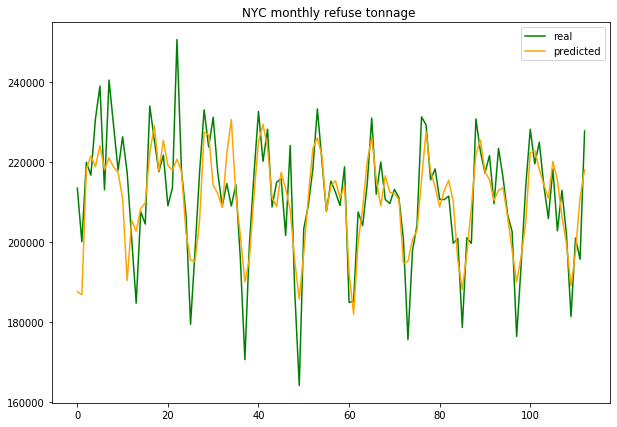

In [15]:
args.training_iter = 1500
nyc_model, nyc_results = training_boro_models("NYC", plot = True, save_results="NYC(epoch=1500)")

In [40]:
get_mse(nyc_results,scale = True)

(0.014180733648628329, 0.006404215474082641)

Trainig epoch: 0, loss 0.7073869109153748
Trainig epoch: 100, loss 0.0019530555000528693
Trainig epoch: 200, loss 0.0017966938903555274
Trainig epoch: 300, loss 0.0015513441758230329
Trainig epoch: 400, loss 0.001248541520908475
Trainig epoch: 500, loss 0.0009518728475086391
Trainig epoch: 600, loss 0.0006960743339732289
Trainig epoch: 700, loss 0.0004955637850798666
Trainig epoch: 800, loss 0.00035075651248916984
Trainig epoch: 900, loss 0.0002530721540097147
Trainig epoch: 1000, loss 0.0001906430843519047
Trainig epoch: 1100, loss 0.00015234056627377868
Trainig epoch: 1200, loss 0.00012976945436093956
Trainig epoch: 1300, loss 0.00011723436182364821
Trainig epoch: 1400, loss 0.00011114079097751528


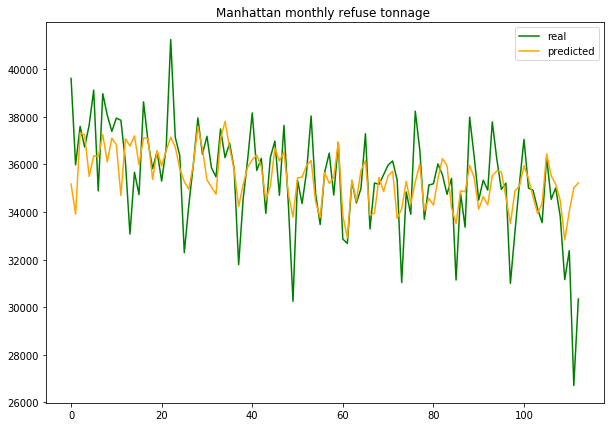

In [15]:
man_model, man_results = training_boro_models("Manhattan", plot = True, save_results="Man(epoch=1500)")

In [23]:
get_mse(man_results,scale = True)

(0.010537694894545202, 0.018935946745137086)

D:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Trainig epoch: 0, loss 0.49677976965904236
Trainig epoch: 100, loss 9.651171421865001e-05
Trainig epoch: 200, loss 6.94244445185177e-05
Trainig epoch: 300, loss 3.9241818740265444e-05
Trainig epoch: 400, loss 1.064753632817883e-05
Trainig epoch: 500, loss 9.573312809152412e-08
Trainig epoch: 600, loss 2.3938816866575507e-06
Trainig epoch: 700, loss 6.275046871451195e-06
Trainig epoch: 800, loss 8.67516610014718e-06
Trainig epoch: 900, loss 9.679834874987137e-06
Trainig epoch: 1000, loss 9.819791557674762e-06
Trainig epoch: 1100, loss 9.490503543929663e-06
Trainig epoch: 1200, loss 8.933373464969918e-06
Trainig epoch: 1300, loss 8.284659088531043e-06
Trainig epoch: 1400, loss 7.622497832926456e-06


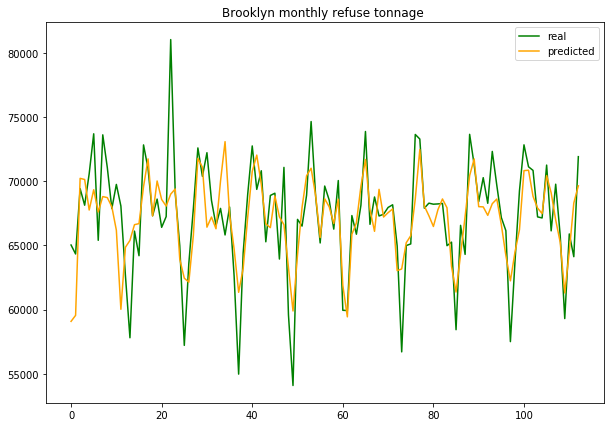

In [8]:
bk_model, bk_results = training_boro_models("Brooklyn", plot = True, save_results="Bk(epoch=1500)")

In [24]:
get_mse(bk_results,scale = True)

(0.014616674693841621, 0.0066635941800310475)

Trainig epoch: 0, loss 0.6772082448005676
Trainig epoch: 100, loss 0.005391352344304323
Trainig epoch: 200, loss 0.0030925783794373274
Trainig epoch: 300, loss 0.0006734372582286596
Trainig epoch: 400, loss 9.34818308451213e-06
Trainig epoch: 500, loss 0.00012072036042809486
Trainig epoch: 600, loss 0.00015748594887554646
Trainig epoch: 700, loss 0.00016785853949841112
Trainig epoch: 800, loss 0.00016906848759390414
Trainig epoch: 900, loss 0.000166946992976591
Trainig epoch: 1000, loss 0.00016428377421107143
Trainig epoch: 1100, loss 0.00016238547686953098
Trainig epoch: 1200, loss 0.00016175262862816453
Trainig epoch: 1300, loss 0.00016248118481598794
Trainig epoch: 1400, loss 0.00016449317627120763


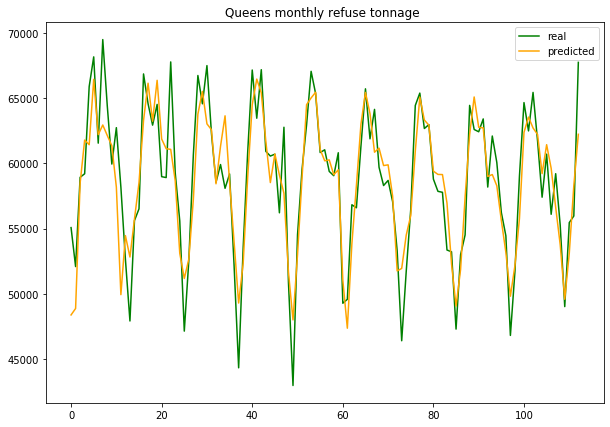

In [12]:
q_model, q_results = training_boro_models("Queens", plot = True, save_results="Q(epoch=1500)")

In [25]:
get_mse(q_results,scale = True)

(0.011817688646906252, 0.006587363801684114)

Trainig epoch: 0, loss 0.3870241343975067
Trainig epoch: 100, loss 0.0004197249363642186
Trainig epoch: 200, loss 0.00037990204873494804
Trainig epoch: 300, loss 0.00032539863605052233
Trainig epoch: 400, loss 0.00026189201162196696
Trainig epoch: 500, loss 0.00019814200641121715
Trainig epoch: 600, loss 0.00014157613622955978
Trainig epoch: 700, loss 9.684225369710475e-05
Trainig epoch: 800, loss 6.511995889013633e-05
Trainig epoch: 900, loss 4.477478432818316e-05
Trainig epoch: 1000, loss 3.292692417744547e-05
Trainig epoch: 1100, loss 2.6836118195205927e-05
Trainig epoch: 1200, loss 2.4517716155969538e-05
Trainig epoch: 1300, loss 2.4714076062082313e-05
Trainig epoch: 1400, loss 2.6700430680648424e-05


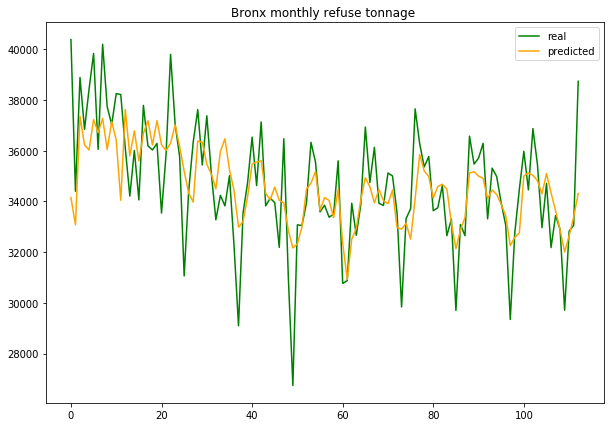

In [13]:
br_model, br_results = training_boro_models("Bronx", plot = True,save_results="Br(epoch=1500)")

In [26]:
get_mse(br_results,scale = True)

(0.018499109435935017, 0.010485746446497371)

Trainig epoch: 0, loss 0.4548060894012451
Trainig epoch: 100, loss 0.002061162143945694
Trainig epoch: 200, loss 0.00041973957559093833
Trainig epoch: 300, loss 0.00010463714716024697
Trainig epoch: 400, loss 0.00029614739469252527
Trainig epoch: 500, loss 0.00024306520936079323
Trainig epoch: 600, loss 0.00019819906447082758
Trainig epoch: 700, loss 0.00017464424308855087
Trainig epoch: 800, loss 0.00016218956443481147
Trainig epoch: 900, loss 0.0001549663720652461
Trainig epoch: 1000, loss 0.00015023647574707866
Trainig epoch: 1100, loss 0.00014674437989015132
Trainig epoch: 1200, loss 0.000143939076224342
Trainig epoch: 1300, loss 0.00014154209929984063
Trainig epoch: 1400, loss 0.00013943960948381573


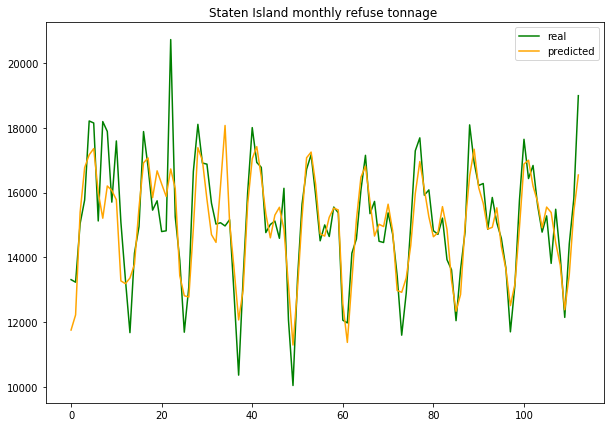

In [14]:
st_model, st_results = training_boro_models("Staten Island", plot = True, save_results="St(epoch=1500)")

In [27]:
get_mse(st_results,scale = True)

(0.009989971345053746, 0.005208084374201159)